## 10-fold CV with 3-layer CNN max pooling on SR images

### Import and env settings

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import os

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

### Variables/parameters used in this notebook

In [12]:
ckpt_path = "./ckpt/reg_lr005/"
os.makedirs(ckpt_path, exist_ok=True)

SR_img_path = '../../data/SR_img/'

num_classes = 5
lr = 0.005
epochs = 120

### Prepare data

In [4]:
'''read label'''

df = pd.read_csv('../../data/images/label_5_cls.csv')
df.head()

labels = df['SalePrice']
labels.shape

(2911,)

In [5]:
'''one-hot encode the labels'''

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
# print(list(integer_encoded))

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = onehot_encoder.fit_transform(integer_encoded)

print('Number of classes: ', len(labels[0]))
print(labels)

Number of classes:  5
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [6]:
'''load SR images'''
images_arr = []

for i in range(1, len(labels)+1):
# for i in range(1, 10):
    img = plt.imread(os.path.join(SR_img_path, 'SR_img_{}.png'.format(i)))
    images_arr.append(img)

images_arr = np.array(images_arr, dtype='float32')
images_arr.shape
    


(2911, 72, 72, 3)

#### train test splitting
- hold out 15% for testing
- use 85% to train model with K-fold CV

In [7]:
ttl_samples = images_arr.shape[0] 
test_ratio = 0.15
test_samples = int(test_ratio * images_arr.shape[0])

train_examples = images_arr[:-1*test_samples]
test_examples = images_arr[-1*test_samples:]
train_labels = labels[:-1*test_samples]
test_labels = labels[-1*test_samples:]


In [8]:
print('train: ', train_examples.shape)
print('test: ', test_examples.shape)
print('train label: ', train_labels.shape)
print('test label: ', test_labels.shape)

train:  (2475, 72, 72, 3)
test:  (436, 72, 72, 3)
train label:  (2475, 5)
test label:  (436, 5)


### Prepare model

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')


def create_model(num_classes=5, lr=0.005):

	# Working
	with tf.device('/cpu:0'):
		data_augmentation = tf.keras.Sequential([ 
			tf.keras.layers.RandomFlip("horizontal", input_shape=(72, 72, 3)),
	  		tf.keras.layers.RandomRotation(0.1),
		    tf.keras.layers.RandomZoom(0.1)
			])


	model = tf.keras.Sequential([
		# data_augmentation,
	  	# tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(72, 72, 3)),
		tf.keras.layers.MaxPooling2D((2, 2)),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.MaxPooling2D((2,2)),
		tf.keras.layers.Dropout(0.1),
	  	tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
	])

	# opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
	opt = tf.keras.optimizers.Adam(lr=lr)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model



Num GPUs Available:  1


In [10]:
model = create_model()
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-30 22:46:16.306437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-30 22:46:16.306594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
# history = model.fit(train_examples, train_labels, epochs=epochs, validation_data=(test_examples, test_labels))

Epoch 1/120


2022-04-30 22:46:18.350847: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-30 22:46:18.628122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 1.2582 - accuracy: 0.4473

2022-04-30 22:46:21.135515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 3s 23ms/step - loss: 1.2582 - accuracy: 0.4473 - val_loss: 0.9388 - val_accuracy: 0.5872
Epoch 2/120
78/78 [==============================] - 1s 15ms/step - loss: 0.8757 - accuracy: 0.6230 - val_loss: 0.6944 - val_accuracy: 0.6789
Epoch 3/120
78/78 [==============================] - 1s 14ms/step - loss: 0.7712 - accuracy: 0.6590 - val_loss: 0.7384 - val_accuracy: 0.6789
Epoch 4/120
78/78 [==============================] - 1s 14ms/step - loss: 0.7085 - accuracy: 0.6848 - val_loss: 0.5879 - val_accuracy: 0.7339
Epoch 5/120
78/78 [==============================] - 1s 14ms/step - loss: 0.6455 - accuracy: 0.7301 - val_loss: 0.6370 - val_accuracy: 0.7064
Epoch 6/120
78/78 [==============================] - 1s 14ms/step - loss: 0.6435 - accuracy: 0.7220 - val_loss: 0.6203 - val_accuracy: 0.7385
Epoch 7/120
78/78 [==============================] - 1s 14ms/step - loss: 0.6509 - accuracy: 0.7224 - val_loss: 0.5530 - val_accuracy: 0.7500
Epoch 8/120
78/78 

### 10-fold CV

In [13]:
from sklearn.model_selection import KFold

# modify to save ckpt for each test
ckpt = os.path.join(ckpt_path, "val_acc_{val_accuracy:.3f}.hdf5")

# training params
epochs = epochs
num_classes = num_classes
lr = lr

# the k for k fold CV
n_split = 10

# for recording best performance
max_acc = 0
best_history = None

'''
k-fold cross validation
Save the best model using validation accuracy as metric
Print the global best performace when finished
'''
for train_index, test_index in KFold(n_split).split(train_examples):

    x_train, x_vad = train_examples[train_index], train_examples[test_index]
    y_train, y_vad = train_labels[train_index], train_labels[test_index]

    model=create_model(num_classes, lr)
  
    # callbacks
    checkpoint_filepath = ckpt
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        mode='auto',
    )

    # Model weights are saved at the end of every epoch, if it's the best seen so far.
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_vad, y_vad),
                        callbacks=[model_checkpoint_callback, early_stopping_callback])

    val_acc = max(history.history['val_accuracy'])
    
    if val_acc > max_acc:
        max_acc = val_acc
        best_history = history
        # print('Best acc so far. Saving params...\n')

print('Finish {}-fold cross validation'.format(n_split))
print('Best performing model has {:.4f} validation accuracy'.format(max_acc))


Epoch 1/120


2022-04-30 22:49:13.820673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.2342 - accuracy: 0.4567
Epoch 1: val_accuracy improved from -inf to 0.48387, saving model to ./ckpt/reg_lr005/val_acc_0.484.hdf5


2022-04-30 22:49:15.199807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 2s 20ms/step - loss: 1.2342 - accuracy: 0.4567 - val_loss: 1.0124 - val_accuracy: 0.4839
Epoch 2/120
67/70 [===========================>..] - ETA: 0s - loss: 0.9037 - accuracy: 0.6045
Epoch 2: val_accuracy improved from 0.48387 to 0.62097, saving model to ./ckpt/reg_lr005/val_acc_0.621.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.9034 - accuracy: 0.6044 - val_loss: 0.8602 - val_accuracy: 0.6210
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 0.8050 - accuracy: 0.6438
Epoch 3: val_accuracy improved from 0.62097 to 0.63306, saving model to ./ckpt/reg_lr005/val_acc_0.633.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.8027 - accuracy: 0.6475 - val_loss: 0.7369 - val_accuracy: 0.6331
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 0.7002 - accuracy: 0.6947
Epoch 4: val_accuracy improved from 0.63306 to 0.69355, saving model to ./ckpt/reg_lr005/val_acc_0.694.hdf5
7

2022-04-30 22:49:36.629001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.2176 - accuracy: 0.4683
Epoch 1: val_accuracy improved from -inf to 0.55242, saving model to ./ckpt/reg_lr005/val_acc_0.552.hdf5
70/70 [==============================] - 2s 21ms/step - loss: 1.2176 - accuracy: 0.4683 - val_loss: 0.9884 - val_accuracy: 0.5524
Epoch 2/120
 5/70 [=>............................] - ETA: 0s - loss: 0.9655 - accuracy: 0.5375

2022-04-30 22:49:38.111825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/70 [===========================>..] - ETA: 0s - loss: 0.9007 - accuracy: 0.6063
Epoch 2: val_accuracy improved from 0.55242 to 0.66935, saving model to ./ckpt/reg_lr005/val_acc_0.669.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.9104 - accuracy: 0.6066 - val_loss: 0.7979 - val_accuracy: 0.6694
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 0.8081 - accuracy: 0.6413
Epoch 3: val_accuracy did not improve from 0.66935
70/70 [==============================] - 1s 14ms/step - loss: 0.8074 - accuracy: 0.6408 - val_loss: 0.8085 - val_accuracy: 0.6492
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 0.7268 - accuracy: 0.6916
Epoch 4: val_accuracy improved from 0.66935 to 0.68548, saving model to ./ckpt/reg_lr005/val_acc_0.685.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.7319 - accuracy: 0.6906 - val_loss: 0.6880 - val_accuracy: 0.6855
Epoch 5/120
69/70 [============================>.] - ETA: 0s - loss: 0

2022-04-30 22:49:51.830141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3393 - accuracy: 0.4401
Epoch 1: val_accuracy improved from -inf to 0.61694, saving model to ./ckpt/reg_lr005/val_acc_0.617.hdf5
70/70 [==============================] - 2s 17ms/step - loss: 1.3393 - accuracy: 0.4401 - val_loss: 1.0064 - val_accuracy: 0.6169
Epoch 2/120
 5/70 [=>............................] - ETA: 0s - loss: 0.8940 - accuracy: 0.6062

2022-04-30 22:49:53.050951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/70 [============================>.] - ETA: 0s - loss: 0.8585 - accuracy: 0.6250
Epoch 2: val_accuracy improved from 0.61694 to 0.66129, saving model to ./ckpt/reg_lr005/val_acc_0.661.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 0.8606 - accuracy: 0.6233 - val_loss: 0.8971 - val_accuracy: 0.6613
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 0.7585 - accuracy: 0.6632
Epoch 3: val_accuracy did not improve from 0.66129
70/70 [==============================] - 1s 14ms/step - loss: 0.7582 - accuracy: 0.6623 - val_loss: 0.9019 - val_accuracy: 0.6210
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.6889
Epoch 4: val_accuracy improved from 0.66129 to 0.70161, saving model to ./ckpt/reg_lr005/val_acc_0.702.hdf5
70/70 [==============================] - 1s 18ms/step - loss: 0.6892 - accuracy: 0.6888 - val_loss: 0.7687 - val_accuracy: 0.7016
Epoch 5/120
69/70 [============================>.] - ETA: 0s - loss: 0

2022-04-30 22:50:12.406655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.4761 - accuracy: 0.3678
Epoch 1: val_accuracy improved from -inf to 0.51613, saving model to ./ckpt/reg_lr005/val_acc_0.516.hdf5
70/70 [==============================] - 2s 18ms/step - loss: 1.4761 - accuracy: 0.3678 - val_loss: 1.1039 - val_accuracy: 0.5161
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 0.9984 - accuracy: 0.5312

2022-04-30 22:50:13.695563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/70 [===========================>..] - ETA: 0s - loss: 0.9097 - accuracy: 0.5947
Epoch 2: val_accuracy improved from 0.51613 to 0.61694, saving model to ./ckpt/reg_lr005/val_acc_0.617.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.9038 - accuracy: 0.5986 - val_loss: 0.8516 - val_accuracy: 0.6169
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 0.8022 - accuracy: 0.6472
Epoch 3: val_accuracy did not improve from 0.61694
70/70 [==============================] - 1s 16ms/step - loss: 0.8032 - accuracy: 0.6462 - val_loss: 0.8827 - val_accuracy: 0.5847
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 0.7564 - accuracy: 0.6719
Epoch 4: val_accuracy improved from 0.61694 to 0.67339, saving model to ./ckpt/reg_lr005/val_acc_0.673.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.7584 - accuracy: 0.6700 - val_loss: 0.7444 - val_accuracy: 0.6734
Epoch 5/120
70/70 [==============================] - ETA: 0s - loss: 0

2022-04-30 22:50:35.561508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.4723 - accuracy: 0.3678
Epoch 1: val_accuracy improved from -inf to 0.56855, saving model to ./ckpt/reg_lr005/val_acc_0.569.hdf5
70/70 [==============================] - 2s 17ms/step - loss: 1.4723 - accuracy: 0.3678 - val_loss: 1.0074 - val_accuracy: 0.5685
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 1.0323 - accuracy: 0.5312

2022-04-30 22:50:36.738278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/70 [============================>.] - ETA: 0s - loss: 0.9559 - accuracy: 0.5804
Epoch 2: val_accuracy improved from 0.56855 to 0.57258, saving model to ./ckpt/reg_lr005/val_acc_0.573.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.9573 - accuracy: 0.5793 - val_loss: 0.8787 - val_accuracy: 0.5726
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 0.8256 - accuracy: 0.6296
Epoch 3: val_accuracy improved from 0.57258 to 0.68952, saving model to ./ckpt/reg_lr005/val_acc_0.690.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.8235 - accuracy: 0.6309 - val_loss: 0.6890 - val_accuracy: 0.6895
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 0.7353 - accuracy: 0.6716
Epoch 4: val_accuracy improved from 0.68952 to 0.71774, saving model to ./ckpt/reg_lr005/val_acc_0.718.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.7380 - accuracy: 0.6704 - val_loss: 0.6520 - val_accuracy: 0.7177
Epoch 5/120
7

2022-04-30 22:50:54.988478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3530 - accuracy: 0.4174
Epoch 1: val_accuracy improved from -inf to 0.55061, saving model to ./ckpt/reg_lr005/val_acc_0.551.hdf5
70/70 [==============================] - 2s 28ms/step - loss: 1.3530 - accuracy: 0.4174 - val_loss: 0.9829 - val_accuracy: 0.5506
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 0.7124 - accuracy: 0.6875

2022-04-30 22:50:56.920529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/70 [===========================>..] - ETA: 0s - loss: 0.8619 - accuracy: 0.6049
Epoch 2: val_accuracy improved from 0.55061 to 0.63563, saving model to ./ckpt/reg_lr005/val_acc_0.636.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.8587 - accuracy: 0.6100 - val_loss: 0.7624 - val_accuracy: 0.6356
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 0.7668 - accuracy: 0.6659
Epoch 3: val_accuracy improved from 0.63563 to 0.65992, saving model to ./ckpt/reg_lr005/val_acc_0.660.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.7663 - accuracy: 0.6652 - val_loss: 0.7396 - val_accuracy: 0.6599
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 0.6861 - accuracy: 0.6982
Epoch 4: val_accuracy improved from 0.65992 to 0.70850, saving model to ./ckpt/reg_lr005/val_acc_0.709.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.6853 - accuracy: 0.6993 - val_loss: 0.6721 - val_accuracy: 0.7085
Epoch 5/120
7

2022-04-30 22:51:17.168265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3285 - accuracy: 0.4215
Epoch 1: val_accuracy improved from -inf to 0.57895, saving model to ./ckpt/reg_lr005/val_acc_0.579.hdf5
70/70 [==============================] - 2s 18ms/step - loss: 1.3285 - accuracy: 0.4215 - val_loss: 0.9609 - val_accuracy: 0.5789
Epoch 2/120


2022-04-30 22:51:18.393965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/70 [============================>.] - ETA: 0s - loss: 0.9226 - accuracy: 0.5951
Epoch 2: val_accuracy improved from 0.57895 to 0.60324, saving model to ./ckpt/reg_lr005/val_acc_0.603.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.9217 - accuracy: 0.5961 - val_loss: 0.8258 - val_accuracy: 0.6032
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 0.8070 - accuracy: 0.6420
Epoch 3: val_accuracy improved from 0.60324 to 0.66397, saving model to ./ckpt/reg_lr005/val_acc_0.664.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.8048 - accuracy: 0.6427 - val_loss: 0.7913 - val_accuracy: 0.6640
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 0.7373 - accuracy: 0.6834
Epoch 4: val_accuracy improved from 0.66397 to 0.68016, saving model to ./ckpt/reg_lr005/val_acc_0.680.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.7372 - accuracy: 0.6827 - val_loss: 0.7424 - val_accuracy: 0.6802
Epoch 5/120
6

2022-04-30 22:51:39.046934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3623 - accuracy: 0.3927
Epoch 1: val_accuracy improved from -inf to 0.54656, saving model to ./ckpt/reg_lr005/val_acc_0.547.hdf5
70/70 [==============================] - 2s 17ms/step - loss: 1.3623 - accuracy: 0.3927 - val_loss: 0.9722 - val_accuracy: 0.5466
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 0.9956 - accuracy: 0.5312

2022-04-30 22:51:40.299676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/70 [============================>.] - ETA: 0s - loss: 0.9705 - accuracy: 0.5786
Epoch 2: val_accuracy improved from 0.54656 to 0.59109, saving model to ./ckpt/reg_lr005/val_acc_0.591.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.9754 - accuracy: 0.5781 - val_loss: 0.8522 - val_accuracy: 0.5911
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 0.8414 - accuracy: 0.6264
Epoch 3: val_accuracy improved from 0.59109 to 0.63968, saving model to ./ckpt/reg_lr005/val_acc_0.640.hdf5
70/70 [==============================] - 1s 17ms/step - loss: 0.8416 - accuracy: 0.6275 - val_loss: 0.8207 - val_accuracy: 0.6397
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 0.7807 - accuracy: 0.6625
Epoch 4: val_accuracy improved from 0.63968 to 0.74899, saving model to ./ckpt/reg_lr005/val_acc_0.749.hdf5
70/70 [==============================] - 1s 18ms/step - loss: 0.7807 - accuracy: 0.6625 - val_loss: 0.6387 - val_accuracy: 0.7490
Epoch 5/120
6

2022-04-30 22:52:02.744315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3127 - accuracy: 0.4255
Epoch 1: val_accuracy improved from -inf to 0.56680, saving model to ./ckpt/reg_lr005/val_acc_0.567.hdf5
70/70 [==============================] - 2s 18ms/step - loss: 1.3127 - accuracy: 0.4255 - val_loss: 0.9486 - val_accuracy: 0.5668
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 1.2861 - accuracy: 0.4375

2022-04-30 22:52:03.992501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/70 [============================>.] - ETA: 0s - loss: 0.9276 - accuracy: 0.5901
Epoch 2: val_accuracy improved from 0.56680 to 0.69231, saving model to ./ckpt/reg_lr005/val_acc_0.692.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.9267 - accuracy: 0.5916 - val_loss: 0.7840 - val_accuracy: 0.6923
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 0.7983 - accuracy: 0.6436
Epoch 3: val_accuracy did not improve from 0.69231
70/70 [==============================] - 1s 16ms/step - loss: 0.7983 - accuracy: 0.6436 - val_loss: 0.7059 - val_accuracy: 0.6518
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 0.7039 - accuracy: 0.7006
Epoch 4: val_accuracy improved from 0.69231 to 0.71255, saving model to ./ckpt/reg_lr005/val_acc_0.713.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.7043 - accuracy: 0.6975 - val_loss: 0.6826 - val_accuracy: 0.7126
Epoch 5/120
69/70 [============================>.] - ETA: 0s - loss: 0

2022-04-30 22:52:28.489187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.3604 - accuracy: 0.4129
Epoch 1: val_accuracy improved from -inf to 0.57085, saving model to ./ckpt/reg_lr005/val_acc_0.571.hdf5
70/70 [==============================] - 3s 27ms/step - loss: 1.3604 - accuracy: 0.4129 - val_loss: 0.9625 - val_accuracy: 0.5709
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 0.9639 - accuracy: 0.6250

2022-04-30 22:52:30.531973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/70 [============================>.] - ETA: 0s - loss: 0.9669 - accuracy: 0.5747
Epoch 2: val_accuracy improved from 0.57085 to 0.57895, saving model to ./ckpt/reg_lr005/val_acc_0.579.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 0.9661 - accuracy: 0.5754 - val_loss: 0.9099 - val_accuracy: 0.5789
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 0.8271 - accuracy: 0.6368
Epoch 3: val_accuracy improved from 0.57895 to 0.63563, saving model to ./ckpt/reg_lr005/val_acc_0.636.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.8264 - accuracy: 0.6378 - val_loss: 0.8250 - val_accuracy: 0.6356
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 0.7510 - accuracy: 0.6625
Epoch 4: val_accuracy improved from 0.63563 to 0.74089, saving model to ./ckpt/reg_lr005/val_acc_0.741.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 0.7510 - accuracy: 0.6625 - val_loss: 0.6629 - val_accuracy: 0.7409
Epoch 5/120
6

### Visualize training result

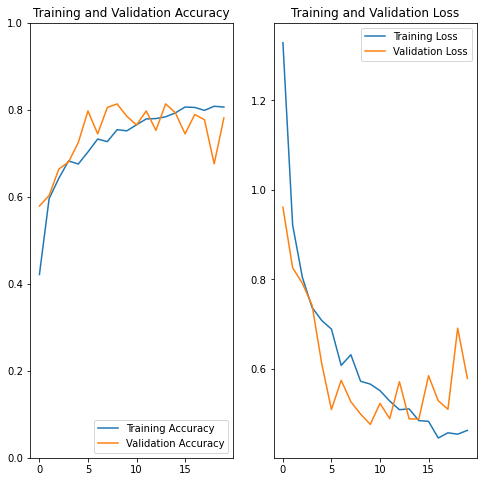

In [14]:
history = best_history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# because of early stopping, can't just use "epochs"
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate on test data

In [25]:
model = create_model(num_classes=num_classes)
model.load_weights(os.path.join(ckpt_path, "val_acc_0.754.hdf5"))

loss, acc = model.evaluate(test_examples, test_labels)

print('\nevaluate on test set:\nloss = {:.5f}\tacc = {:.3f}%'.format(loss, acc*100))

 7/14 [==============>...............] - ETA: 0s - loss: 0.4102 - accuracy: 0.8259

2022-04-30 22:55:50.271133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 11ms/step - loss: 0.4835 - accuracy: 0.8096

evaluate on test set:
loss = 0.48346	acc = 80.963%


In [151]:
%reset -f